## 1. [70 pts] By using three classifiers, decision tree, random forest and neural network and at least 2 different hyper-parameter settings for each, generate operating points and plot them on a ROC. Do not hesitate to use/modify the ROC plot code in the module notebook. In case you do not see enough variety in Pd-Pf you might need to work on the classifiers set and/or hyper parameters. And do not hesitate to try hundreds, if necessary, since the ROCis just a natural scatter plot.

There was not much differentiation, even after changing the parameters a lot. I reduced the hyperparameters down so that this program does not take a ridiculous amount of time, but it may still take a while for MLP. I use kcross fold and then use my test set for problem 4.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

In [2]:
#format dataframe
fake = pd.read_csv('fake.csv')
news = pd.read_csv('true.csv')
news['class'] = 0 
fake['class'] = 1
news = news.append(fake).reset_index(drop=True)
news

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


### Reusable functions

In [3]:
#using kfold for validation
x_train, x_test, y_train, y_test = train_test_split(news["title"], news['class'], test_size=0.2, random_state=14)
kf = KFold(n_splits=3, random_state=14, shuffle=True)
vector = TfidfVectorizer(stop_words="english", max_features=50,max_df=0.7)

In [4]:
#groups data
def formatPD(data, target):
    return data.groupby(target).mean().reset_index()

In [5]:
def graph(data):
    FPR = data['Pf']
    TPR = data['Pd']
    FPR, TPR = zip(*sorted(zip(FPR, TPR)))
    fpr = [0.]+list(FPR)+[1.]; tpr = [0.]+list(TPR)+[1.]

    # Plot
    fig, ax = plt.subplots()
    plt.plot(fpr, tpr, ':', label='ROC')
    plt.scatter(FPR, TPR, 50, color='red', marker='o', label='operating points')
    plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')

    # Labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [6]:
#takes in classifier and data to return score metrics
def learn(classifier, vector_train, vector_test, k_y_train, k_y_test, class1, class2, hyper1, hyper2):
    FPR, TPR = [], []
    classifier.fit(vector_train, k_y_train)
    k_y_pred = classifier.predict(vector_test)
    tn, fp, fn, tp = confusion_matrix(k_y_test, k_y_pred).ravel()
    TPR += [tp/(tp+fn)]  # Pd percent of correct true vs all true
    FPR += [fp/(fp+tn)]  # Pf percent of false true vs all negative
    return pd.Series({'Score': classifier.score(vector_test, k_y_test), class1:hyper1 , class2: hyper2, 'Pd': TPR[-1], 'Pf':FPR[-1]}), tp, fp, fn, tn

### Decision Tree

In [7]:
max_node=[2,50]
max_depth = [1,50]

In [8]:
treePD = pd.DataFrame(columns=['Score', 'Nodes', 'Depth', 'Pd', 'Pf'])
for leaf in max_node:
    for depth in max_depth:
        for train_index, test_index in kf.split(x_train):             
            k_x_train, k_x_test = x_train.iloc[train_index], x_train.iloc[test_index]
            k_y_train, k_y_test = y_train.iloc[train_index], y_train.iloc[test_index]
            vector_train = vector.fit_transform(k_x_train)
            vector_test = vector.transform(k_x_test)
            treePD = treePD.append(learn(DecisionTreeClassifier(random_state=14, max_leaf_nodes=leaf, max_depth=depth), vector_train, vector_test, k_y_train, k_y_test, 'Nodes', 'Depth', leaf, depth)[0], ignore_index=True)
            print(leaf, depth)

2 1
2 1
2 1
2 50
2 50
2 50
50 1
50 1
50 1
50 50
50 50
50 50


In [9]:
treePD_format = formatPD(treePD, ['Nodes', 'Depth'])
treePD_format

,Nodes,Depth,Score,Pd,Pf
0,2.0,1.0,0.660198,0.351896,0.001577
1,2.0,50.0,0.660198,0.351896,0.001577
2,50.0,1.0,0.660198,0.351896,0.001577
3,50.0,50.0,0.813102,0.700917,0.063816


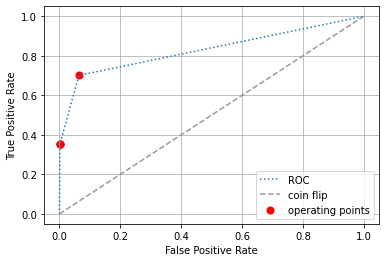

In [10]:
graph(treePD_format)

### Forest

In [11]:
trees = [1,25,50]
#reuse max_depth

In [12]:
forestPD = pd.DataFrame(columns=['Score', 'Trees', 'Depth', 'Pd', 'Pf'])
for tree_size in trees:
    for depth in max_depth:
         for train_index, test_index in kf.split(x_train):             
            k_x_train, k_x_test = x_train.iloc[train_index], x_train.iloc[test_index]
            k_y_train, k_y_test = y_train.iloc[train_index], y_train.iloc[test_index]
            vector_train = vector.fit_transform(k_x_train)
            vector_test = vector.transform(k_x_test)
            forestPD = forestPD.append(learn(RandomForestClassifier(random_state=14, n_estimators=tree_size, max_depth=depth), vector_train, vector_test, k_y_train, k_y_test, 'Trees', 'Depth', tree_size, depth)[0], ignore_index=True)
            print(tree_size, depth)

1 1
1 1
1 1
1 50
1 50
1 50
25 1
25 1
25 1
25 50
25 50
25 50
50 1
50 1
50 1
50 50
50 50
50 50


In [13]:
forestPD_format = formatPD(forestPD, ['Trees', 'Depth'])
forestPD_format

,Trees,Depth,Score,Pd,Pf
0,1.0,1.0,0.533938,0.997449,0.974523
1,1.0,50.0,0.806671,0.702037,0.078516
2,25.0,1.0,0.621944,0.979070,0.769589
3,25.0,50.0,0.815302,0.709052,0.068144
4,50.0,1.0,0.683949,0.897396,0.550327
5,50.0,50.0,0.815524,0.707829,0.066326


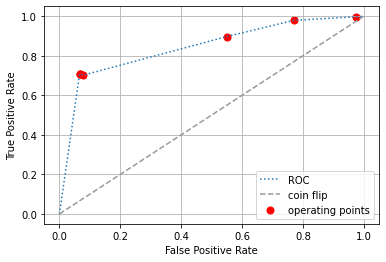

In [14]:
graph(forestPD_format)

### Neural Net (Multilayer Perceptron)

In [15]:
solver = ['adam', 'sgd']
learning_rate=[0.00001,0.01]

In [16]:
mlpPD = pd.DataFrame(columns=['Score', 'Solver', 'Rate', 'Pd', 'Pf'])
for solve in solver:
    for rate in learning_rate:
         for train_index, test_index in kf.split(x_train):             
            k_x_train, k_x_test = x_train.iloc[train_index], x_train.iloc[test_index]
            k_y_train, k_y_test = y_train.iloc[train_index], y_train.iloc[test_index]
            vector_train = vector.fit_transform(k_x_train)
            vector_test = vector.transform(k_x_test)
            mlpPD = mlpPD.append(learn(MLPClassifier(random_state=14, max_iter=500, solver=solve, learning_rate_init=rate), vector_train, vector_test, k_y_train, k_y_test, 'Solver', 'Rate', solve, rate)[0], ignore_index=True)
            print(solve, rate)

adam 1e-05
adam 1e-05
adam 1e-05
adam 0.01
adam 0.01
adam 0.01
sgd 1e-05
sgd 1e-05
sgd 1e-05
sgd 0.01
sgd 0.01
sgd 0.01


In [17]:
mlpPD_format = formatPD(mlpPD, ['Solver', 'Rate'])
mlpPD_format

,Solver,Rate,Score,Pd,Pf
0,adam,0.00001,0.813770,0.706500,0.068545
1,adam,0.01000,0.812406,0.712087,0.077550
2,sgd,0.00001,0.527814,0.835747,0.809181
3,sgd,0.01000,0.817501,0.711822,0.066576


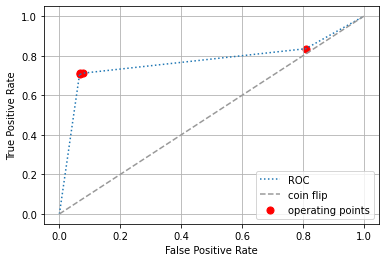

In [18]:
graph(mlpPD_format)

## 2. [10 pts] What kind of behavior would you expect to see in Pd – Pf interaction of an ROC plot? Do you see it in yours?
I expect to see as the Pd percentage rises, pf should fall. The logic here is that if you correctly classify all true positive, then there will be no false positive. This behavior is not correct as pf can still be high with a high pd score. For example, if a model classifies everything as positive, then fn and tn will both be zero. TPR will be tp/(tp+0) = 1 and FPR will be fp/(fp+0)=1. For the most part, the pd-pf interaction should show rapid improvement in pd (in my case approaching .8) and slight growth in fp (in my case approaching .1).

## 3. [10 pts] From the ROC plot that you created make a selection of the classifier and hyperparameter setting for this problem. Note that we are classifying fake news so your conclusion might be subjective but has to be supported by your findings.
I will choose a random forest with 25 trees and 50 depth. I am also going to increase vector feature size. All my classifiers had pretty bad accuracy, and this only had 81% but this is still better than the majority. It has a high pd score with a low pf score in comparison. If we are trying to call something fake news, then a false positive means we are calling real news fake while a false negative means we are calling fake news real. I see both of these as bad, but I am not sure which is worse. I am going to choose calling real news fake as worse, so I will try to limit false positives.

## 4. [10 pts] Try adding text column to the features. Report the performance of the new classifier model. Why do you think it is much higher than the previous one which only uses title?
This classifier actually did really well. There were only 40 missclassifications and it got an accuracy of 99.56%. Also, the Pd was very high with the Pf being very low.
This did much better for multiple reasons.  First, it is using a larger dataset to train on. Second, I increased the max_features by double. Third, and most impotantly, including the text feature is very important because I believe this is where fake news can be determined. A title can be very misleading but in context (throught the text feature), it could make sense. By explaining the title in text, we can find fake news.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(news[["title",'text']], news['class'], test_size=0.2, random_state=14)
vector = TfidfVectorizer(stop_words="english", max_features=100,max_df=0.7)
vector_train_text = vector.fit_transform(x_train['text'])
vector_test_text= vector.transform(x_test['text'])
vector_train_title = vector.fit_transform(x_train['title'])
vector_test_title = vector.transform(x_test['title'])
vector_train = np.concatenate((vector_train_title.todense(), vector_train_text.todense()), axis=1)
vector_test = np.concatenate((vector_test_title.todense(), vector_test_text.todense()), axis=1)
text_forest,tp, fp, fn, tn = learn(RandomForestClassifier(random_state=14, n_estimators=25, max_depth=50), vector_train, vector_test, y_train, y_test, 'Trees', 'Depth', 25, 50)
print(text_forest)
print(tp,fp)
print(fn,tn)

Score     0.995657
Trees    25.000000
Depth    50.000000
Pd        0.994884
Pf        0.003497
dtype: float64
4667 15
24 4274
